# Preparazione Dati e Estrazione Features - GTZAN

Questo notebook esegue la preparazione dei dati audio e l'estrazione delle caratteristiche dal dataset GTZAN per la classificazione di generi musicali.

## Obiettivi:
1. 🎵 Caricare e ispezionare il dataset GTZAN
2. 📊 Creare un DataFrame con tutti i file audio e le etichette
3. 🔊 Estrarre features audio usando librosa
4. 💾 Salvare i dati preprocessati per il training

## Prerequisiti:
✅ Dataset GTZAN scaricato e organizzato in `data/gtzan/genres/`  
✅ Librerie: librosa, pandas, numpy, matplotlib  
✅ Ambiente virtuale attivo

In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# --- 1. Definizione dei Percorsi e delle Costanti ---

# Trova la root del progetto (dove è il dataset)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
dataset_path = project_root / "data" / "gtzan" / "genres"

print(f"📁 Project root: {project_root}")
print(f"📂 Dataset path: {dataset_path}")
print(f"✅ Dataset exists: {dataset_path.exists()}")

if not dataset_path.exists():
    print("❌ Dataset non trovato! Assicurati di aver eseguito il notebook di download.")
    print("💡 Esegui prima: notebooks/00_kaggle_dataset_download.ipynb")
else:
    print(f"🎵 Generi disponibili: {[d.name for d in dataset_path.iterdir() if d.is_dir()]}")

# Percorso della cartella principale del dataset GTZAN
DATASET_PATH = str(dataset_path)

# Parametri per l'analisi audio
SAMPLE_RATE = 22050   # Frequenza di campionamento standard per MIR
DURATION = 30         # Durata di ogni clip in secondi
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

print(f"\n🔧 Parametri audio:")
print(f"   Sample rate: {SAMPLE_RATE} Hz")
print(f"   Durata: {DURATION} secondi")
print(f"   Campioni per traccia: {SAMPLES_PER_TRACK}")

📁 Project root: /home/alepot55/Desktop/projects/naml_project
📂 Dataset path: /home/alepot55/Desktop/projects/naml_project/data/gtzan/genres
✅ Dataset exists: True
🎵 Generi disponibili: ['pop', 'country', 'rock', 'reggae', 'jazz', 'blues', 'disco', 'hiphop', 'classical', 'metal']

🔧 Parametri audio:
   Sample rate: 22050 Hz
   Durata: 30 secondi
   Campioni per traccia: 661500


## 🎵 Ispezione File Audio di Esempio

🎵 File di esempio: /home/alepot55/Desktop/projects/naml_project/data/gtzan/genres/pop/pop.00045.wav
🎭 Genere: pop

📊 Informazioni audio:
   File: pop.00045.wav
   Frequenza di campionamento: 22050 Hz
   Numero di campioni: 661,504
   Durata: 30.00 secondi
   Ampiezza min/max: -0.998 / 0.986


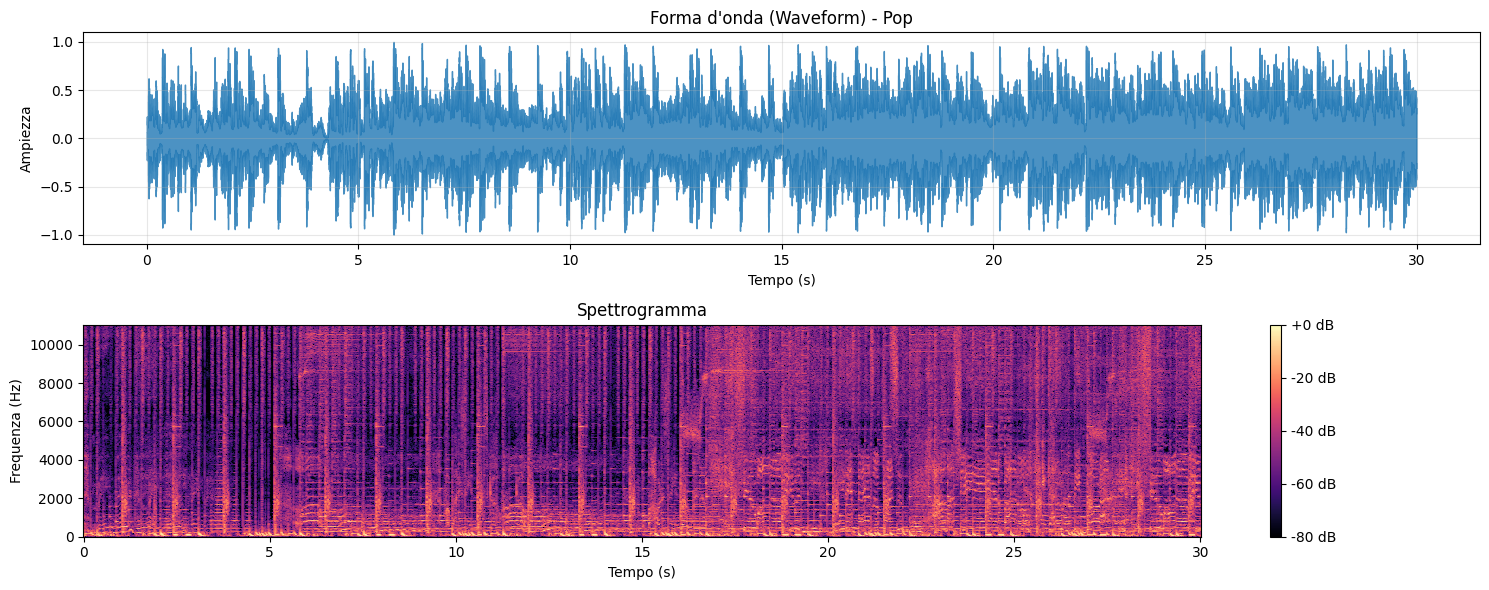

In [2]:
# --- 2. Ispezione di un File Audio Esempio ---

# Trova il primo file audio disponibile
sample_file_path = None
sample_genre = None

for genre_dir in dataset_path.iterdir():
    if genre_dir.is_dir():
        audio_files = list(genre_dir.glob("*.wav"))
        if audio_files:
            sample_file_path = audio_files[0]
            sample_genre = genre_dir.name
            break

if sample_file_path:
    print(f"🎵 File di esempio: {sample_file_path}")
    print(f"🎭 Genere: {sample_genre}")
    
    # Carichiamo il file audio
    # librosa.load carica il file audio come un array numpy (time series)
    # e restituisce anche la frequenza di campionamento (sr)
    signal, sr = librosa.load(str(sample_file_path), sr=SAMPLE_RATE)
    
    print(f"\n📊 Informazioni audio:")
    print(f"   File: {sample_file_path.name}")
    print(f"   Frequenza di campionamento: {sr} Hz")
    print(f"   Numero di campioni: {signal.shape[0]:,}")
    print(f"   Durata: {signal.shape[0] / sr:.2f} secondi")
    print(f"   Ampiezza min/max: {signal.min():.3f} / {signal.max():.3f}")
    
    # Visualizziamo la forma d'onda
    plt.figure(figsize=(15, 6))
    
    # Subplot 1: Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(signal, sr=sr, alpha=0.8)
    plt.title(f"Forma d'onda (Waveform) - {sample_genre.title()}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ampiezza")
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Spettrogramma
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spettrogramma')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequenza (Hz)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Nessun file audio trovato nel dataset!")

## 📊 Preparazione Dataset

🔍 Scansione dataset in: /home/alepot55/Desktop/projects/naml_project/data/gtzan/genres
🎵          pop: 100 file
🎵      country: 100 file
🎵         rock: 100 file
🎵       reggae: 100 file
🎵         jazz: 100 file
🎵        blues: 100 file
🎵        disco: 100 file
🎵       hiphop: 100 file
🎵    classical: 100 file
🎵        metal: 100 file
📁 Totale file audio: 1000

📊 Struttura del DataFrame:
   Shape: (1000, 5)
   Colonne: ['filepath', 'label', 'genre', 'label_encoded', 'label_id']

🏷️  Mapping dei generi:
    0: blues
    1: classical
    2: country
    3: disco
    4: hiphop
    5: jazz
    6: metal
    7: pop
    8: reggae
    9: rock

📈 Distribuzione per genere:
          blues: 100 file
      classical: 100 file
        country: 100 file
          disco: 100 file
         hiphop: 100 file
           jazz: 100 file
          metal: 100 file
            pop: 100 file
         reggae: 100 file
           rock: 100 file


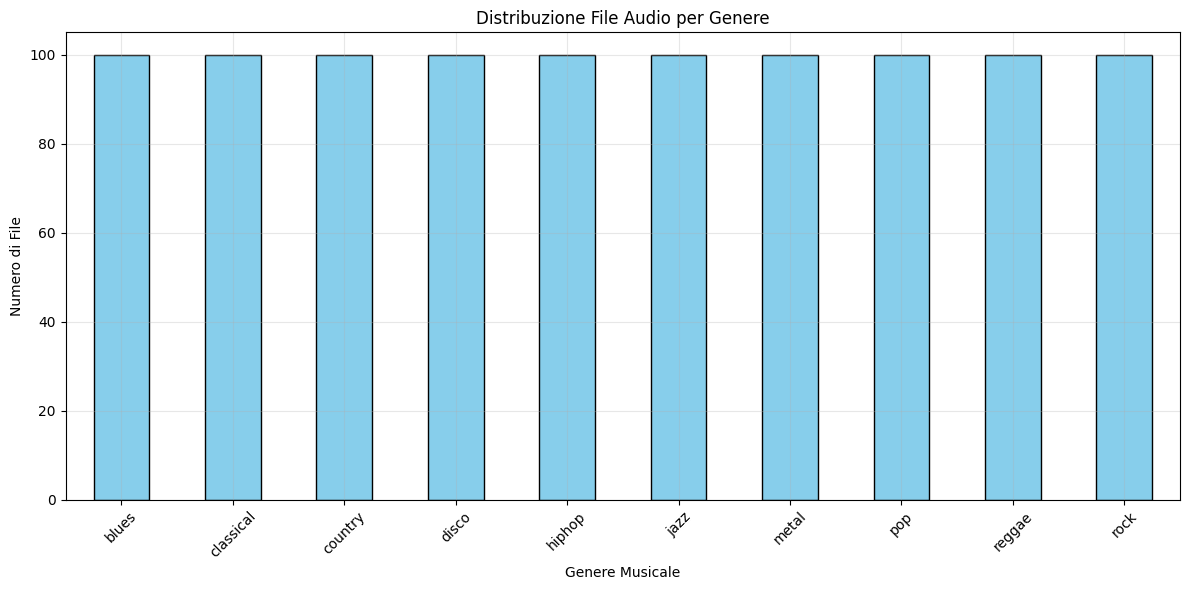


📋 Preview DataFrame:
                                            filepath label genre  \
0  /home/alepot55/Desktop/projects/naml_project/d...   pop   pop   
1  /home/alepot55/Desktop/projects/naml_project/d...   pop   pop   
2  /home/alepot55/Desktop/projects/naml_project/d...   pop   pop   
3  /home/alepot55/Desktop/projects/naml_project/d...   pop   pop   
4  /home/alepot55/Desktop/projects/naml_project/d...   pop   pop   

   label_encoded  label_id  
0              7         7  
1              7         7  
2              7         7  
3              7         7  
4              7         7  


In [3]:
# --- 3. Preparazione dei Dati per l'Elaborazione ---

# Creiamo un DataFrame per mappare ogni file al suo genere
# Questo ci aiuterà a organizzare il training
data = {"filepath": [], "label": [], "genre": []}

print(f"🔍 Scansione dataset in: {DATASET_PATH}")
print("=" * 50)

total_files = 0
for genre_dir in dataset_path.iterdir():
    if genre_dir.is_dir():
        genre_label = genre_dir.name
        audio_files = list(genre_dir.glob("*.wav"))
        
        print(f"🎵 {genre_label:>12}: {len(audio_files):>3} file")
        
        for audio_file in audio_files:
            data["filepath"].append(str(audio_file))
            data["label"].append(genre_label)
            data["genre"].append(genre_label)
            total_files += 1

print("=" * 50)
print(f"📁 Totale file audio: {total_files}")

# Convertiamo in un DataFrame Pandas per una gestione più semplice
df = pd.DataFrame(data)

# Mappiamo le etichette testuali in numeri interi per il modello
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Creiamo anche un mapping manuale
genre_mapping = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
df['label_id'] = df['label'].map(genre_mapping)

print(f"\n📊 Struttura del DataFrame:")
print(f"   Shape: {df.shape}")
print(f"   Colonne: {list(df.columns)}")

print(f"\n🏷️  Mapping dei generi:")
for genre, id_num in sorted(genre_mapping.items()):
    print(f"   {id_num:>2}: {genre}")

print(f"\n📈 Distribuzione per genere:")
genre_counts = df['label'].value_counts().sort_index()
for genre, count in genre_counts.items():
    print(f"   {genre:>12}: {count:>3} file")

# Visualizzazione distribuzione
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuzione File Audio per Genere')
plt.xlabel('Genere Musicale')
plt.ylabel('Numero di File')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostra preview del DataFrame
print(f"\n📋 Preview DataFrame:")
print(df.head())

## 🎼 Estrazione Features Audio

Estraiamo diverse caratteristiche audio che sono utili per la classificazione di generi musicali:

- **MFCC** (Mel-Frequency Cepstral Coefficients): Caratteristiche spettrali
- **Chroma**: Contenuto armonico
- **Spectral Centroid**: Luminosità del suono  
- **Spectral Rolloff**: Forma dello spettro
- **Zero Crossing Rate**: Frequenza di attraversamento dello zero
- **Tempo**: Battiti per minuto stimati

In [4]:
# --- 4. Definizione Funzione di Estrazione Features ---

def extract_features(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """
    Estrae features audio da un file usando librosa.
    
    Args:
        file_path (str): Percorso del file audio
        sr (int): Sample rate
        duration (int): Durata in secondi
    
    Returns:
        dict: Dizionario con tutte le features estratte
    """
    try:
        # Carica il file audio
        signal, _ = librosa.load(file_path, sr=sr, duration=duration)
        
        # Assicuriamoci che abbia la durata corretta
        if len(signal) < sr * duration:
            # Pad con zeri se troppo corto
            signal = np.pad(signal, (0, sr * duration - len(signal)))
        else:
            # Taglia se troppo lungo
            signal = signal[:sr * duration]
        
        features = {}
        
        # 1. MFCC (Mel-Frequency Cepstral Coefficients)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
        features.update({
            f'mfcc_{i}_mean': np.mean(mfcc[i]) for i in range(13)
        })
        features.update({
            f'mfcc_{i}_std': np.std(mfcc[i]) for i in range(13)
        })
        
        # 2. Chroma Features
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
        features.update({
            f'chroma_{i}_mean': np.mean(chroma[i]) for i in range(12)
        })
        features.update({
            f'chroma_{i}_std': np.std(chroma[i]) for i in range(12)
        })
        
        # 3. Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_std'] = np.std(spectral_centroid)
        
        # 4. Spectral Rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)
        
        # 5. Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(signal)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        
        # 6. Tempo
        tempo, _ = librosa.beat.beat_track(y=signal, sr=sr)
        features['tempo'] = tempo
        
        # 7. Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
        
        # 8. RMS Energy
        rms = librosa.feature.rms(y=signal)
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)
        
        return features
        
    except Exception as e:
        print(f"❌ Errore nell'elaborazione di {file_path}: {e}")
        return None

# Test della funzione con il file di esempio
if sample_file_path:
    print("🧪 Test estrazione features...")
    test_features = extract_features(str(sample_file_path))
    
    if test_features:
        print(f"✅ Features estratte: {len(test_features)}")
        print("\n📊 Prime 10 features:")
        for i, (key, value) in enumerate(list(test_features.items())[:10]):
            print(f"   {key}: {value:.4f}")
        print("   ...")
    else:
        print("❌ Errore nell'estrazione features")

🧪 Test estrazione features...
✅ Features estratte: 61

📊 Prime 10 features:
   mfcc_0_mean: -71.6150
   mfcc_1_mean: 81.1212
   mfcc_2_mean: 16.3557
   mfcc_3_mean: 8.9505
   mfcc_4_mean: 13.8184
   mfcc_5_mean: -0.7372
   mfcc_6_mean: 12.5223
   mfcc_7_mean: -0.6394
   mfcc_8_mean: 3.0430
   mfcc_9_mean: 3.0548
   ...


In [5]:
# --- 5. Estrazione Features per Tutto il Dataset ---

print("🚀 Inizio estrazione features per tutto il dataset...")
print("⏳ Questo processo richiederà alcuni minuti...")

features_list = []
failed_files = []

total_files = len(df)
for idx, row in df.iterrows():
    file_path = row['filepath']
    
    # Progress indicator
    if (idx + 1) % 50 == 0 or idx == 0: # type: ignore
        print(f"📊 Processati {idx + 1}/{total_files} file ({(idx + 1)/total_files*100:.1f}%)") # type: ignore
    
    # Estrai features
    features = extract_features(file_path)
    
    if features:
        # Aggiungi metadati
        features['filepath'] = file_path
        features['label'] = row['label']
        features['label_id'] = row['label_id']
        features['genre'] = row['genre']
        
        features_list.append(features)
    else:
        failed_files.append(file_path)

print(f"\n✅ Estrazione completata!")
print(f"📊 File processati con successo: {len(features_list)}")
print(f"❌ File falliti: {len(failed_files)}")

if failed_files:
    print("🔍 File che hanno dato errore:")
    for failed_file in failed_files[:5]:  # Mostra solo i primi 5
        print(f"   - {failed_file}")
    if len(failed_files) > 5:
        print(f"   ... e altri {len(failed_files) - 5}")

# Crea DataFrame con le features
features_df = pd.DataFrame(features_list)

print(f"\n📋 Dataset features:")
print(f"   Shape: {features_df.shape}")
print(f"   Colonne: {features_df.shape[1]}")

# Separazione features numeriche da metadati
feature_columns = [col for col in features_df.columns 
                  if col not in ['filepath', 'label', 'label_id', 'genre']]
metadata_columns = ['filepath', 'label', 'label_id', 'genre']

print(f"   Features numeriche: {len(feature_columns)}")
print(f"   Metadati: {len(metadata_columns)}")

# Preview del dataset
print(f"\n📊 Preview features dataset:")
print(features_df[metadata_columns + feature_columns[:5]].head())

🚀 Inizio estrazione features per tutto il dataset...
⏳ Questo processo richiederà alcuni minuti...
📊 Processati 1/1000 file (0.1%)
📊 Processati 50/1000 file (5.0%)
📊 Processati 100/1000 file (10.0%)
📊 Processati 150/1000 file (15.0%)
📊 Processati 200/1000 file (20.0%)
📊 Processati 250/1000 file (25.0%)
📊 Processati 300/1000 file (30.0%)
📊 Processati 350/1000 file (35.0%)
📊 Processati 400/1000 file (40.0%)
❌ Errore nell'elaborazione di /home/alepot55/Desktop/projects/naml_project/data/gtzan/genres/jazz/jazz.00054.wav: 
📊 Processati 450/1000 file (45.0%)
📊 Processati 500/1000 file (50.0%)
📊 Processati 550/1000 file (55.0%)
📊 Processati 600/1000 file (60.0%)
📊 Processati 650/1000 file (65.0%)
📊 Processati 700/1000 file (70.0%)
📊 Processati 750/1000 file (75.0%)
📊 Processati 800/1000 file (80.0%)
📊 Processati 850/1000 file (85.0%)
📊 Processati 900/1000 file (90.0%)


KeyboardInterrupt: 

## 📈 Analisi e Visualizzazione Features

In [ ]:
# --- 6. Analisi Statistiche delle Features ---

# Fix tempo feature - convert arrays to scalars
if 'tempo' in features_df.columns:
    features_df['tempo'] = features_df['tempo'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

# Statistiche descrittive
print("📊 Statistiche descrittive delle features:")
print("=" * 60)

# Solo features numeriche (ora che tempo è stato convertito)
numeric_features = features_df[feature_columns]
stats = numeric_features.describe()

# Mostra statistiche per alcune features chiave
key_features = ['tempo', 'spectral_centroid_mean', 'zcr_mean', 'rms_mean']
key_features = [f for f in key_features if f in feature_columns]

print(f"📋 Statistiche features chiave:")
for feature in key_features:
    print(f"\n🎵 {feature}:")
    print(f"   Min: {stats.loc['min', feature]:.3f}")
    print(f"   Mean: {stats.loc['mean', feature]:.3f}")
    print(f"   Max: {stats.loc['max', feature]:.3f}")
    print(f"   Std: {stats.loc['std', feature]:.3f}")

# Analisi per genere
print(f"\n🎭 Analisi per genere:")
print("=" * 60)

for feature in key_features:
    print(f"\n📊 {feature} per genere:")
    genre_stats = features_df.groupby('label')[feature].agg(['mean', 'std']).round(3)
    print(genre_stats)

# Correlazione tra features
print(f"\n🔗 Analisi correlazioni:")
correlation_matrix = numeric_features.corr()

# Trova le correlazioni più forti (escludendo autocorrelazioni)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # Soglia per correlazione alta
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))

if high_corr_pairs:
    print("⚠️  Features altamente correlate (|r| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Prime 10
        print(f"   {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("✅ Nessuna correlazione molto alta trovata")

📊 Statistiche descrittive delle features:
📋 Statistiche features chiave:

🎵 tempo:
   Min: 58.727
   Mean: 119.383
   Max: 234.908
   Std: 28.207

🎵 spectral_centroid_mean:
   Min: 570.151
   Mean: 2202.442
   Max: 4434.949
   Std: 716.097

🎵 zcr_mean:
   Min: 0.022
   Mean: 0.104
   Max: 0.275
   Std: 0.042

🎵 rms_mean:
   Min: 0.005
   Mean: 0.131
   Max: 0.398
   Std: 0.066

🎭 Analisi per genere:

📊 tempo per genere:
              mean     std
label                     
blues      120.782  31.767
classical  126.456  33.505
country    110.859  29.640
disco      120.342  14.224
hiphop     113.976  28.969
jazz       114.937  30.002
metal      124.874  25.121
pop        112.760  24.636
reggae     129.364  29.484
rock       119.431  24.877

📊 spectral_centroid_mean per genere:
               mean      std
label                       
blues      1727.667  515.496
classical  1354.120  348.227
country    1896.191  575.779
disco      2620.062  478.727
hiphop     2524.692  479.284
jazz       

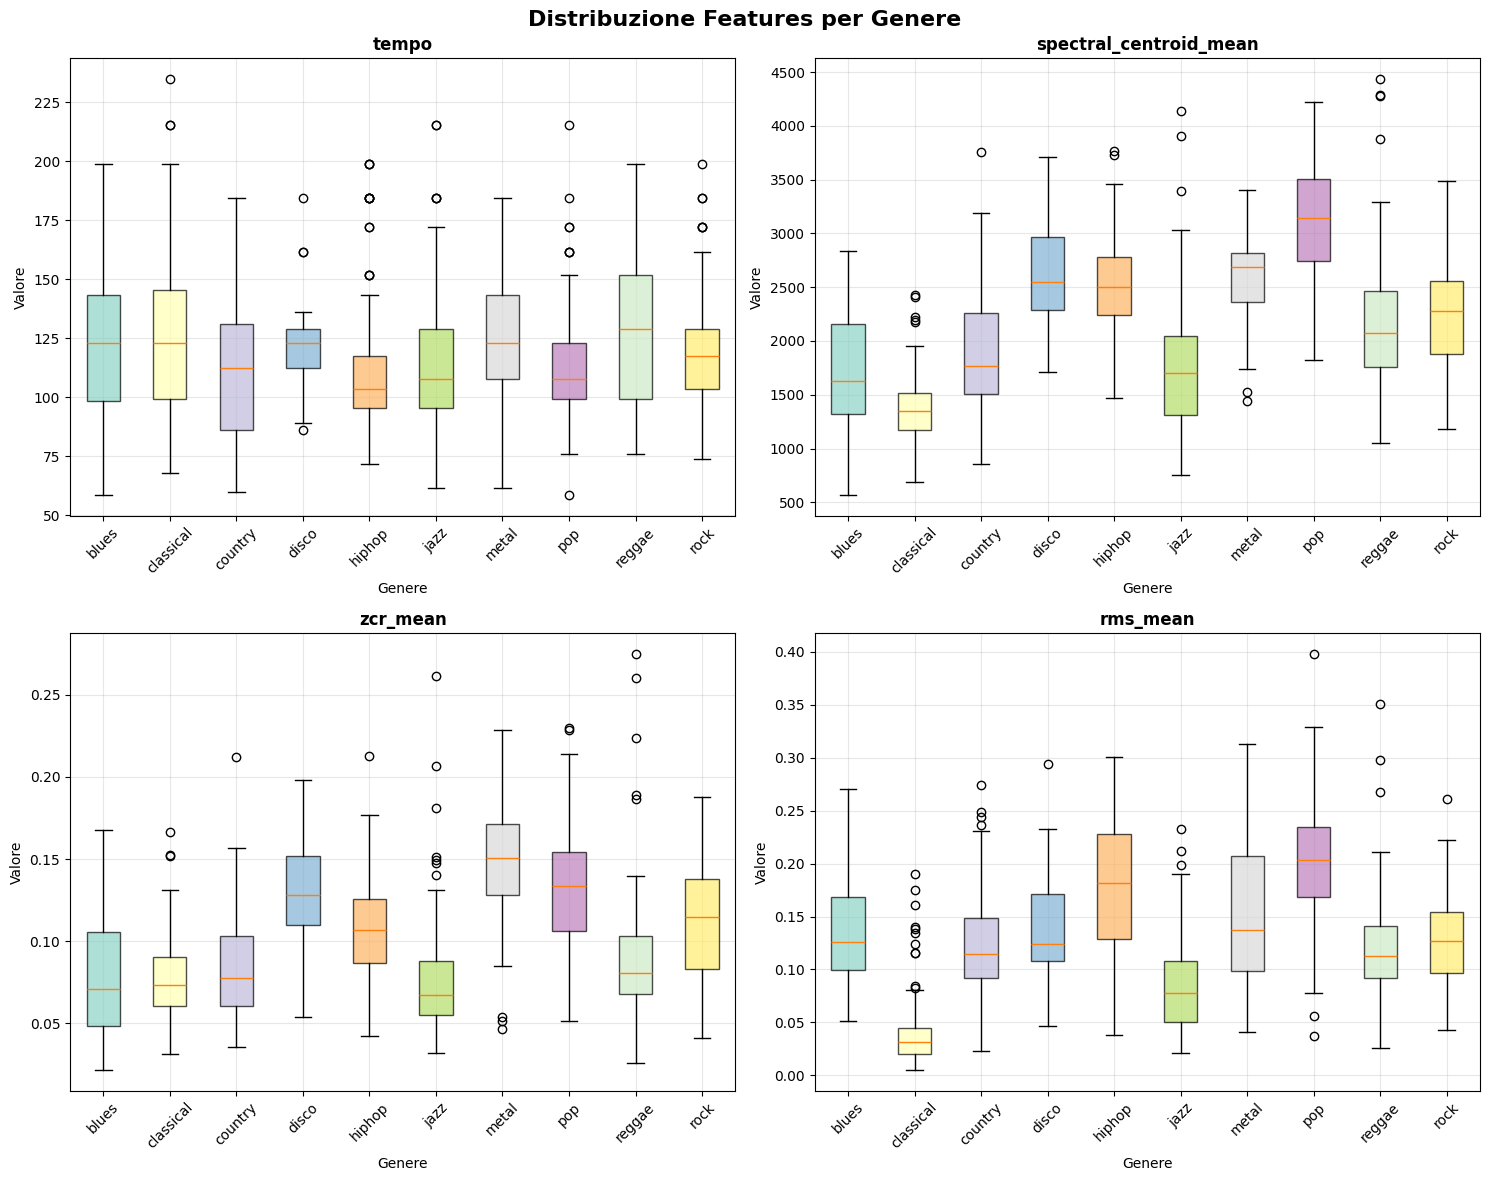

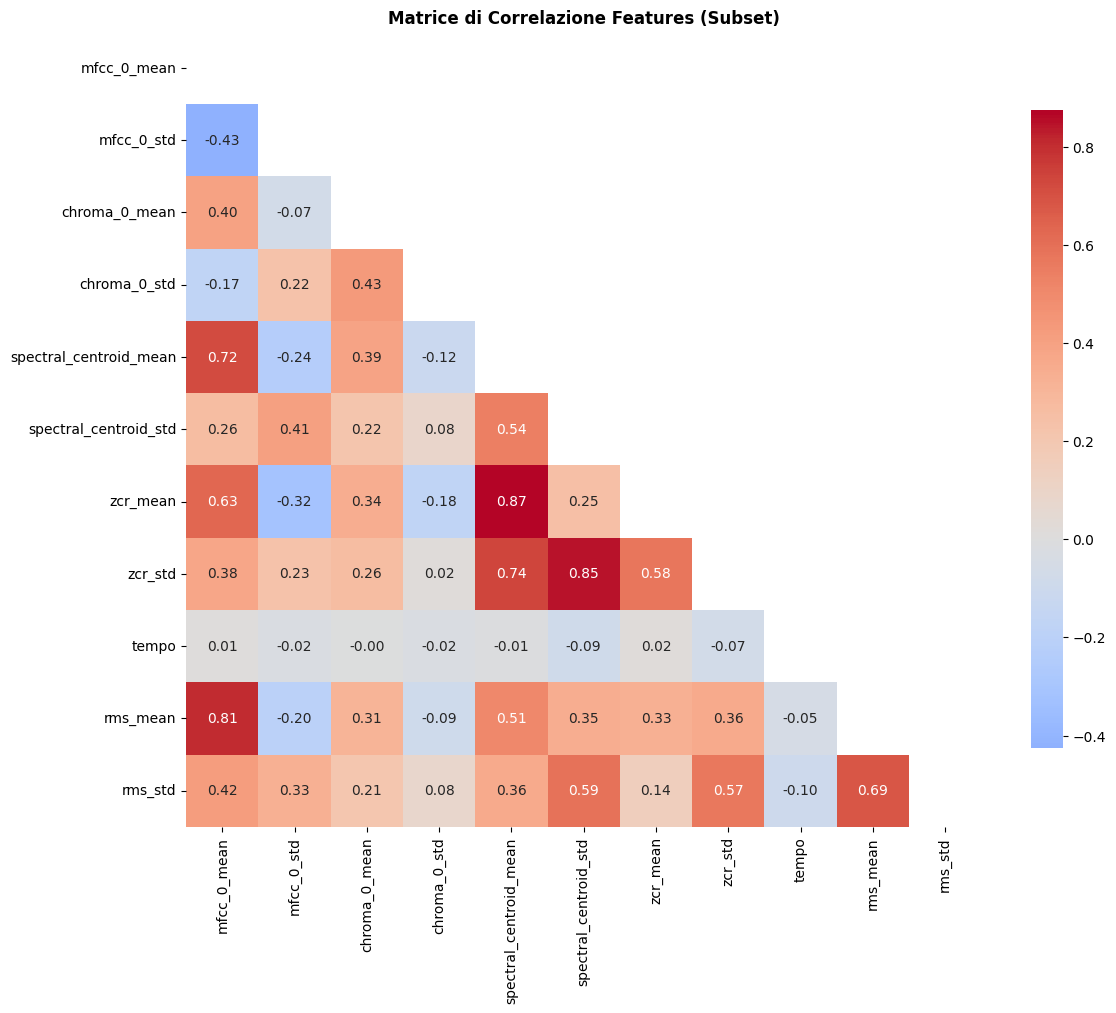

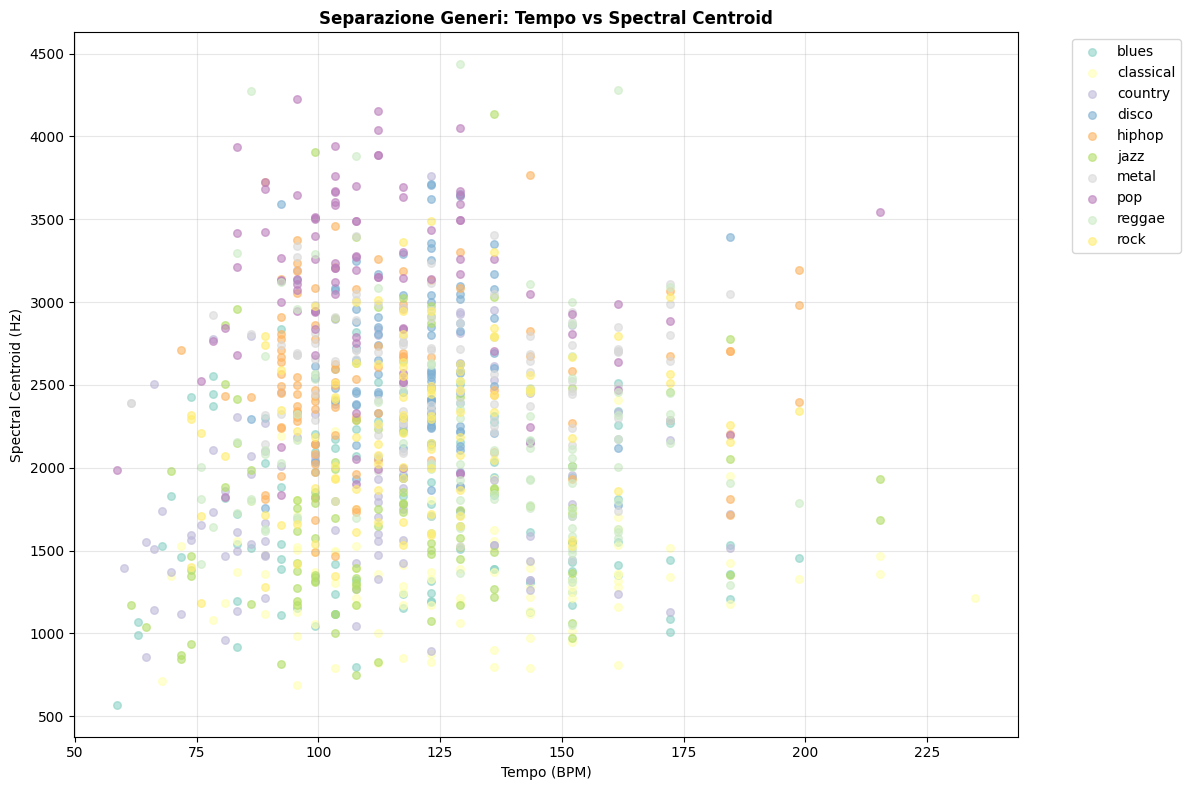

📊 Visualizzazioni completate!


In [ ]:
# --- 7. Visualizzazioni Features ---

# Setup per i grafici
plt.style.use('default')
colors = plt.cm.Set3(np.linspace(0, 1, len(features_df['label'].unique()))) # type: ignore

# 1. Distribuzione di alcune features chiave per genere
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuzione Features per Genere', fontsize=16, fontweight='bold')

key_features_plot = ['tempo', 'spectral_centroid_mean', 'zcr_mean', 'rms_mean']
key_features_plot = [f for f in key_features_plot if f in feature_columns]

for idx, feature in enumerate(key_features_plot[:4]):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Box plot per genere
    data_by_genre = [features_df[features_df['label'] == genre][feature].values 
                     for genre in sorted(features_df['label'].unique())]
    
    box_plot = ax.boxplot(data_by_genre, labels=sorted(features_df['label'].unique()), 
                         patch_artist=True)
    
    # Colori per i box
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_xlabel('Genere')
    ax.set_ylabel('Valore')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Heatmap correlazione (solo per un subset di features)
plt.figure(figsize=(12, 10))

# Seleziona un subset di features interessanti per la visualizzazione
interesting_features = [f for f in feature_columns if any(keyword in f.lower() 
                       for keyword in ['tempo', 'spectral_centroid', 'zcr', 'rms', 'mfcc_0', 'chroma_0'])][:15]

if len(interesting_features) > 0:
    corr_subset = features_df[interesting_features].corr()
    
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))
    sns.heatmap(corr_subset, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Matrice di Correlazione Features (Subset)', fontweight='bold')
    plt.tight_layout()
    plt.show()

# 3. Scatter plot 2D per visualizzare separazione tra generi
plt.figure(figsize=(12, 8))

if 'tempo' in feature_columns and 'spectral_centroid_mean' in feature_columns:
    for i, genre in enumerate(sorted(features_df['label'].unique())):
        genre_data = features_df[features_df['label'] == genre]
        plt.scatter(genre_data['tempo'], genre_data['spectral_centroid_mean'], 
                   c=[colors[i]], label=genre, alpha=0.6, s=30)
    
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Spectral Centroid (Hz)')
    plt.title('Separazione Generi: Tempo vs Spectral Centroid', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("📊 Visualizzazioni completate!")

## 💾 Salvataggio Dati Processati

In [ ]:
# --- 8. Salvataggio Dataset Processato ---

# Crea cartella per i dati processati
processed_data_dir = project_root / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

print(f"💾 Salvataggio dati in: {processed_data_dir}")

# 1. Salva il dataset completo con features
features_file = processed_data_dir / "gtzan_features.csv"
features_df.to_csv(features_file, index=False)
print(f"✅ Dataset features salvato: {features_file}")
print(f"   Shape: {features_df.shape}")

# 2. Salva solo le features numeriche (per ML)
numeric_features_df = features_df[feature_columns + ['label', 'label_id']]
numeric_file = processed_data_dir / "gtzan_features_numeric.csv"
numeric_features_df.to_csv(numeric_file, index=False)
print(f"✅ Features numeriche salvate: {numeric_file}")
print(f"   Shape: {numeric_features_df.shape}")

# 3. Salva il mapping dei generi
mapping_file = processed_data_dir / "genre_mapping.csv"
mapping_df = pd.DataFrame(list(genre_mapping.items()), columns=['genre', 'label_id'])
mapping_df.to_csv(mapping_file, index=False)
print(f"✅ Mapping generi salvato: {mapping_file}")

# 4. Salva metadati del preprocessing
metadata = {
    'sample_rate': SAMPLE_RATE,
    'duration': DURATION,
    'n_samples': len(features_df),
    'n_features': len(feature_columns),
    'n_genres': len(genre_mapping),
    'genres': list(genre_mapping.keys()),
    'feature_columns': feature_columns,
    'failed_files': len(failed_files)
}

metadata_file = processed_data_dir / "preprocessing_metadata.txt"
with open(metadata_file, 'w') as f:
    f.write("GTZAN Dataset - Preprocessing Metadata\n")
    f.write("=" * 50 + "\n\n")
    for key, value in metadata.items():
        f.write(f"{key}: {value}\n")

print(f"✅ Metadati salvati: {metadata_file}")

# 5. Normalizzazione features (per modelli ML)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(numeric_features_df[feature_columns])

# Salva features normalizzate
normalized_df = pd.DataFrame(features_normalized, columns=feature_columns)
normalized_df['label'] = numeric_features_df['label'].values
normalized_df['label_id'] = numeric_features_df['label_id'].values

normalized_file = processed_data_dir / "gtzan_features_normalized.csv"
normalized_df.to_csv(normalized_file, index=False)
print(f"✅ Features normalizzate salvate: {normalized_file}")

# Salva anche il scaler per riutilizzo
import joblib
scaler_file = processed_data_dir / "feature_scaler.pkl"
joblib.dump(scaler, scaler_file)
print(f"✅ Scaler salvato: {scaler_file}")

print(f"\n🎉 PREPROCESSING COMPLETATO!")
print("=" * 50)
print(f"📊 File processati: {len(features_df)}")
print(f"🎭 Generi: {len(genre_mapping)}")
print(f"🔢 Features estratte: {len(feature_columns)}")
print(f"📁 File salvati in: {processed_data_dir}")
print("\n✅ Dati pronti per il training del modello!")

💾 Salvataggio dati in: /home/alepot55/Desktop/projects/naml_project/data/processed
✅ Dataset features salvato: /home/alepot55/Desktop/projects/naml_project/data/processed/gtzan_features.csv
   Shape: (999, 65)
✅ Features numeriche salvate: /home/alepot55/Desktop/projects/naml_project/data/processed/gtzan_features_numeric.csv
   Shape: (999, 63)
✅ Mapping generi salvato: /home/alepot55/Desktop/projects/naml_project/data/processed/genre_mapping.csv
✅ Metadati salvati: /home/alepot55/Desktop/projects/naml_project/data/processed/preprocessing_metadata.txt
✅ Features normalizzate salvate: /home/alepot55/Desktop/projects/naml_project/data/processed/gtzan_features_normalized.csv
✅ Scaler salvato: /home/alepot55/Desktop/projects/naml_project/data/processed/feature_scaler.pkl

🎉 PREPROCESSING COMPLETATO!
📊 File processati: 999
🎭 Generi: 10
🔢 Features estratte: 61
📁 File salvati in: /home/alepot55/Desktop/projects/naml_project/data/processed

✅ Dati pronti per il training del modello!
